In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

np.random.seed(0)

## Generate data, Estimators

In [15]:
# params
p = 200
c2 = 30
n2 = c2 * p
sigma = 5.0

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

def te_target(X1, X2, beta_s, beta_t, w, sigma_2 = sigma, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def mtl_target(X1, X2, beta_s, beta_t, w, n1, n2, Sigma_1_sqrt = np.eye(p), Sigma_2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma**2 * (n1 + n2) * np.trace(K)
    model_shift_bias = n1 * (np.linalg.norm(K @ X2.T @ X2 @ beta_diff) ** 2)
    model_shift_bias += n2 * w**2 * (np.linalg.norm(K @ X1.T @ X1 @ beta_diff) ** 2)
    return (model_shift_bias + var) / (n1 + n2)

## Find optimal w

In [16]:
def mtt_opt_w(X1, X2, beta_s, beta_t, n1, n2, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f_val(w):
        return mtl_target(X1, X2, beta_s, beta_t, w, n1, n2)
    
    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f_val, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
    
    plt.figure(c)
    plt.plot(x_list, fun_list)
    
    return x_list[np.argmin(fun_list)]

def tl_opt_w(X1, X2, beta_s, beta_t, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f(w):
        return te_target(X1, X2, beta_s, beta_t, w)

    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
        
    plt.figure(c)
    plt.plot(x_list, fun_list)
        
    return x_list[np.argmin(fun_list)]

## Test errors and transfer

Test error: STL 0.8628737208799517 MTL 0.7363639780435413 OPT_W 1.0179035737601565
Positive transfer
0.12677484787018256 0.0032081758050691725 39.516178530449686
Provably positive
0.09337474160020194 4.386625258399797


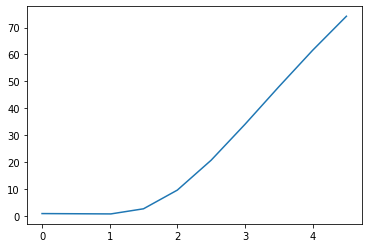

In [18]:
def test_errors_and_transfer(c1, d):
    n1 = c1 * p
    X1 = np.random.randn(n1, p)

    beta_s = beta_t + d * np.random.randn(p, 1)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    te_beta_t = te_target(X1, X2, beta_t, beta_t, 0)

    w_hat = tl_opt_w(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, w_hat)
    print('Test error:', 'STL', te_beta_t, 'MTL', te_beta_st, 'OPT_W', w_hat)

    if te_beta_st <= te_beta_t:
        print('Positive transfer')
    else:
        print('Negative transfer')
        
    delta_beta = p * ((1 - w_hat)**2 + d**2) * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    print(delta_var, delta_beta, delta_var / delta_beta)

    if delta_var / delta_beta >= deviation_ub:
        print('Provably positive')
    elif delta_var / delta_beta <= deviation_lb:
        print('Provably negative')

    print(deviation_lb, deviation_ub)
    
test_errors_and_transfer(5, 0.02)

## Plot the effect of task distance

In [6]:
d_list = [0.01 * i for i in range(1, 21)]
te_mtl_list = []

delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

for d in d_list:
    beta_s = beta_t + d * np.random.randn(p, 1)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
    hat_w = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w)
    
    #te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
    te_mtl_list.append(te_beta_st)
    
    delta_beta = ((1 - hat_w)**2 + d**2) * delta_beta_base    
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    if delta_var / delta_beta > deviation_ub:
        provable_pos[0].append(d)
        provable_pos[1].append(te_beta_st)
    elif delta_var / delta_beta < deviation_lb:    
        provable_neg[0].append(d)
        provable_neg[1].append(te_beta_st)
    else:
        unknown[0].append(d)
        unknown[1].append(te_beta_st)

NameError: name 'opt_w_val' is not defined

In [ ]:
te_beta_t = te_target(X1, X2, beta_s, beta_t, 0)

plt.figure(figsize=(6,3.5))

plt.scatter(provable_pos[0], provable_pos[1], marker='+', s=100, lw=4, c='r', label='Provably positive: our result')
plt.scatter(provable_neg[0], provable_neg[1], marker='_', s=100, lw=4, c='r', label='Provably negative: our result')
plt.scatter(unknown[0], unknown[1], marker='o', s=20, lw=4, c='y')
plt.plot(d_list, te_mtl_list, c='k', lw=2, label='Multi-task training')
plt.plot(d_list, [te_beta_t] * len(d_list), lw=2.5, c='k', ls='dotted', label='Single-task training')

plt.xlabel(r'Distance between task models $d$', fontsize=12)
plt.ylabel('Test error on the target task', fontsize=12)
plt.grid(0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('model_shift_phase_transition.eps')

## Plot the effect of source task data size